28.556791286385046
8
0.6839756652271053


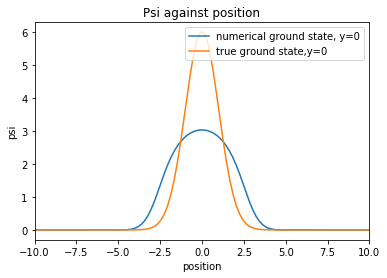

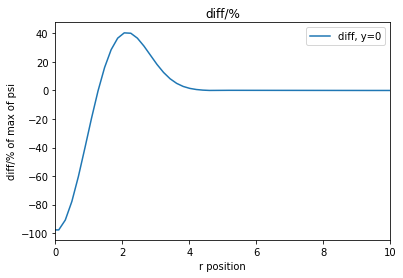

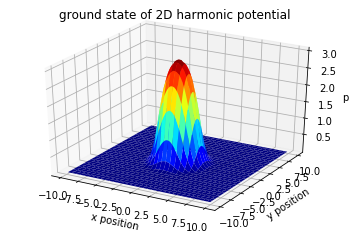

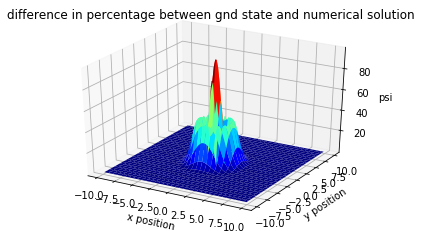

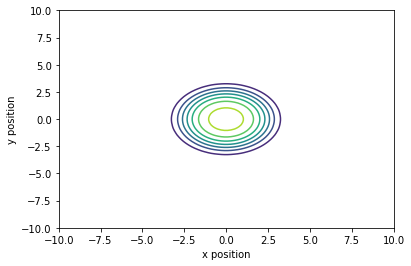

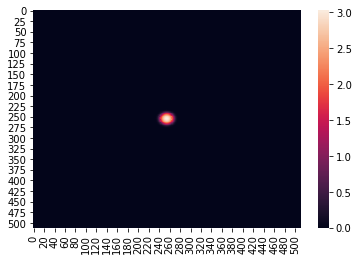

In [42]:
import numpy as np
import scipy.constants as sc
from scipy.fft import fft,ifft,fftfreq
import matplotlib.pyplot as plt
from numpy import linalg as LA
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm_notebook
import seaborn as sns
import mpl_toolkits.mplot3d as mplot3d
from numpy.fft import fft2,ifft2

N=512
##should set N as a power of 2 to speed up fast fourier transforms
No = 3e3 #number of particles
m = 2.7774e-25
w = 100*np.pi
gamma = 8#ratio of wz to w, large for large wz
size = 50 #max radius
dx = 2 * size/N
dt = -0.1j/gamma

x = np.linspace(-size,size,N)
x = x.reshape(-1,1).repeat(len(x),1)
y = x.T
kx = fftfreq(len(x),dx/(2*np.pi)).reshape(-1,1).repeat(len(x),1) #defining the kx values
ky = kx.T #defining the ky values
k_mag=np.sqrt(kx**2+ky**2)
T = 0.5*(kx**2+ky**2) #kinetic energy 2D array

##harmonic potential
xs = np.sqrt(sc.hbar/(m*w)) # scaling parameter of dimensionless length
##box potential
#xs = 1e-5
a = 5.1e-9
gs =4*np.pi*a*No/xs 
g = 4*np.pi*(sc.hbar**2)*a/m
eps = 1/gamma ## matters for beta_2D

mu = 6.98 #dipole moment in units of Bohr magneton
mu_B =9.2740100783e-24
Cdd = sc.mu_0*(mu*mu_B)**2
lamda = (m*No*Cdd)/(3*(sc.hbar**2)*xs) 
# dimensionless variables
nx = 0#1/(2**0.5)
ny = 0#1/(2**0.5) 
nz = 1#1/(3**0.5) #components of normalised vector of magnetic polarisation
beta_2D = gs-lamda+3*lamda*(nz**2)
beta_2D /= eps*(2*np.pi)**0.5
D = 3*lamda/(4*np.pi)##book keeping for stability
#Edd = Cdd/(3*g)

r=np.sqrt(x**2+y**2) #gives the value of r for each point
##harmonic well
def V(psi):
    return 0.5*(r**2) + beta_2D*np.abs(psi)**2#+gs*np.abs(psi)**2

psi =np.exp(-(r**2)) #initial guess for harmonic potential
psi /= LA.norm(psi) ## not sure this is needed
# #circular box potential

# def V(psi):
#     V_bools = np.abs(r)>=box
#     out = np.inf*V_bools
#     out = np.nan_to_num(out,posinf=np.inf)
#     out = out + gs*np.abs(psi)**2 + dd_cont(psi)
#     return out

# def psi_init(x):
#         cos_values = 1#np.cos(np.pi*x/2*box)+2*np.cos(3*np.pi*x/2*box)
#         cos_bools = (np.abs(r)<box)
#         return cos_values*cos_bools
# psi = psi_init(x)

def dd_quasi_2D(psi):
    out = fft2(np.abs(psi)**2)##this should be a gaussian
    out /= LA.norm(out)
    #out =np.abs(out) ##not sure about this
    out *= ((nz**2 -nx**2)*(kx**2) + (nz**2 -ny**2)*(ky**2)-2*nx*ny*kx*ky)/k_mag
    #out *= k_mag #for nz=1
    out = np.nan_to_num(out)
    out *= -3*lamda/2 
    return out 




def exp_fourier_quasi_2D(psi): # includes kinetic and dd contribution
    #psi /= LA.norm(psi)
    return np.exp(-1j*dt*(dd_quasi_2D(psi)+T))
## for this to not blow up, following inequality must hold
#k_mag>=3*lamda*psi**2 in k space
## for this, psi is normalised within the function (has to be in k space already)
#before applying the exponential

for i in tqdm_notebook(range(1000),leave = False):
    psi = np.exp(-0.5j*dt*V(psi))*psi
    psi = exp_fourier_quasi_2D(psi)*fft2(psi)/LA.norm(fft2(psi))
    psi = ifft2(psi)
    psi /= LA.norm(psi)
    psi *= np.exp(-0.5j*dt*V(psi))
    psi /= LA.norm(psi)
##it has to be in this order and separated like this to ensure psi 
#is in the right space for the functions
psi *= np.sqrt(No)

##harmonic ground state
gnd_state = np.exp((-(r**2)/2))
gnd_state /= LA.norm(gnd_state)
gnd_state *= np.sqrt(No)
diff = np.abs(psi)-np.abs(gnd_state)

midway_index = int((N+1)/2)
print(D)
print(gamma)
print(Edd)
plt.plot(x[:,0],np.abs(psi[:,midway_index]), label ="numerical ground state, y=0")
plt.plot(x[:,0],gnd_state[:,midway_index], label ="true ground state,y=0")
plt.xlim(-10,10)
plt.xlabel('position')
plt.ylabel('psi')    
plt.legend()
plt.title('Psi against position')
plt.show() 

plt.plot(x[:,0],100*diff[:,midway_index]/np.max(psi),label="diff, y=0")
plt.xlabel('r position')
plt.ylabel('diff/% of max of psi')
#plt.ylim(-1,1)
plt.xlim(0,10)
plt.legend()
plt.title('diff/%')
plt.show() # plots psi against x

fig = plt.figure()
ax = plt.axes(projection='3d')
bools = ((np.abs(x) <= 10)*(np.abs(y) <= 10)).ravel()##sets region for graph to show
n_ = int(np.sqrt(sum(bools)))
ax.plot_surface(x.ravel()[bools].reshape((n_,n_)),
                y.ravel()[bools].reshape((n_,n_)),
                np.abs(psi).ravel()[bools].reshape((n_,n_)),
                cmap='jet')
ax.set_title('ground state of 2D harmonic potential')
ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_zlabel('psi')
plt.show()

ax = plt.axes(projection='3d')
diff_perc = 100*diff/np.max(psi)
ax.plot_surface(x.ravel()[bools].reshape((n_,n_)),
                y.ravel()[bools].reshape((n_,n_)),
                np.abs(diff_perc).ravel()[bools].reshape((n_,n_)),
                cmap='jet')
ax.set_title('difference in percentage between gnd state and numerical solution')
ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_zlabel('psi')

fig,ax = plt.subplots()
ax.contour(x,y,np.abs(psi))
ax.set_ylim(-10,10)
ax.set_xlim(-10,10)
ax.set_xlabel('x position')
ax.set_ylabel('y position')
plt.show()

sns.heatmap(np.abs(psi))
plt.show()    

In [11]:
beta_2D

132169.1785917057

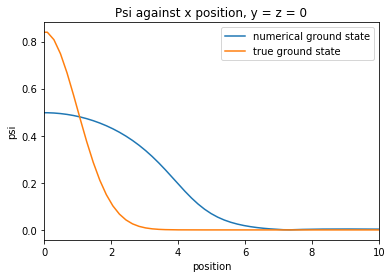

Zvalue = 0


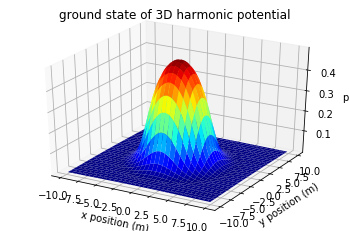

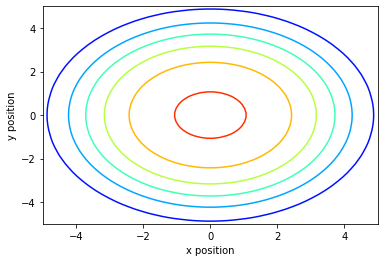

In [25]:
psi_3D = psi[:,:,np.newaxis].repeat(N,2) #repeats over 3rd axis
z = np.linspace(-size/gamma,size/gamma,N).reshape(1,1,-1).repeat(N,0).repeat(N,1)
dz = dx/gamma
x_3D = x[:,:,np.newaxis].repeat(N,2)
y_3D = y[:,:,np.newaxis].repeat(N,2)
z_ansatz = np.exp((-(z/eps)**2)/2)
z_ansatz /= (eps**0.5)*(np.pi**0.25)

psi_3D *= z_ansatz
psi_3D /= np.sqrt(np.sum(r*(np.abs(psi_3D)**2)))    
psi_3D *= np.sqrt(No)

r = np.sqrt(x_3D**2 + y_3D**2)

##harmonic ground state
gnd_state = np.exp((-(r**2)/2))*z_ansatz
gnd_state /= np.sqrt(2*np.pi*np.sum(r*(np.abs(gnd_state)**2)))    
gnd_state *= np.sqrt(No)

diff = np.abs(psi)-np.abs(gnd_state)

midway_index = int((N-1)/2)

plt.plot(x_3D[midway_index:,0,0],np.abs(psi_3D[midway_index:,midway_index,midway_index]), label ="numerical ground state")
plt.plot(x_3D[midway_index:,0,0],gnd_state[midway_index:,midway_index,midway_index], label ="true ground state")
plt.xlim(0,10)
plt.xlabel('position')
plt.ylabel('psi')    
plt.legend()
plt.title('Psi against x position, y = z = 0')
plt.show()


q = int(N/2+float(input("Zvalue = "))/dz) #converts z value to the corresponding element in the x,y,psi arrays

fig=plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x_3D[:,:,q].ravel()[bools].reshape((n_,n_)),
                y_3D[:,:,q].ravel()[bools].reshape((n_,n_)),
                np.abs(psi_3D[:,:,q]).ravel()[bools].reshape((n_,n_)),
                cmap='jet')
ax.set_title('ground state of 3D harmonic potential')
ax.set_xlabel('x position (m)')
ax.set_ylabel('y position (m)')
ax.set_zlabel('psi')

plt.show()

fig,ax = plt.subplots()
ax.contour(x_3D[:,:,q], y_3D[:,:,q], np.abs(psi_3D[:,:,q]), cmap='jet')
ax.set_ylim(-5,5)
ax.set_xlim(-5,5)
ax.set_xlabel('x position')
ax.set_ylabel('y position')
plt.show()

